In [1]:
import pyvisa as visa
import time
import numpy as np
from pymeasure.instruments.keithley import Keithley2400
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from UtilsBasic import *

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import pylab as pl
from IPython import display
N = 100000 # minimum digit 10uA
import datetime
print(datetime.datetime.now())
#from field_control import vsm_set_field, set_field, read_field
import os
rm = visa.ResourceManager()
rm.list_resources()

def connect(address, name=None, logs=None):
    rm = visa.ResourceManager()
    if address is None:
        return None
    else:
        try:
            if not name:
                device = rm.open_resource(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.query("*IDN?").strip()))

                print(device.query("*IDN?"))
            else:
                device = Keithley2400(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.id.strip()))

                print(device.id)
                # check connection
            return device
        except Exception as e:
            if logs:
                logs.add("error: {}".format(e))
            print(e)
            return None

from UtilsPPMS import *
ppms = Dynacool('192.168.0.7')
# ppms.setField(0)
# ppms.setTemperature(300)
# ppms.waitForField()
# ppms.waitForTemperature()

2023-03-23 13:04:58.771988


In [2]:
print(ppms.getTemperature()[1])

300.0314025878906


In [3]:
def plotRvsT(file_name):
    display.clear_output(wait=True)
    #Plot current data
    hlength = 0
    with open(file_name) as myFile:
        for num, line in enumerate(myFile, 1):
            if 'Temp' in line:
                hlength = num-1

    df = pd.read_csv(file_name, header=hlength)
    
    plt.clf()
    fig,ax=plt.subplots()
    plt.suptitle(file_name.split('/')[-1]+'1')
    

    ax.plot(df.Temp,df.average_v/df.dc_current, color='k', linestyle='-',marker='o', markersize='2',linewidth=1)
    ax.ticklabel_format(useOffset=False)
    ax.set_xlabel('Temperature(K)')
    ax.set_ylabel('R$_{xx}$ ($\Omega$)')

    plt.tick_params(direction='in', which='both', right=True, top=True)
    #plt.tick_params(which='major', length=6)
    #plt.tick_params(which='minor', length=3)
    plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    plt.rcParams['font.family'] = "Arial"    
    
    fig.savefig(file_name[:-4]+'.png', dpi=600)
    display.display(plt.gcf())

In [4]:
dc_2400_id = 15
nanovolt_id = 17

dc = Keithley2400("GPIB::{}".format(dc_2400_id))
volt = rm.open_resource('GPIB0::{}::INSTR'.format(nanovolt_id))

def measure_resistance(dc, volt, dc_current=100e-6, measure_points=30, skip_points=5, time_per_point=0.1):
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 1e-6   # Sets the source current range to 10 mA
    dc.compliance_voltage = 105        # Sets the compliance voltage to 10 V
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    time.sleep(6)
    v_up = []
    for i in range(30):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up.append(float(volt.query("fetch?")))
    v_up = sorted(v_up)
    v_up = v_up[3: -3]
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down = []
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down.append(float(volt.query("fetch?")))
    
    dc.shutdown() 
    
    v_down = sorted(v_down)
    v_down = v_down[3: -3]
    
    average_v = (np.array(v_up).mean() - np.array(v_down).mean())/2
    std_v = (np.array(v_up).std() + np.array(v_down).std())/2
    return average_v, std_v

def VoltMeasWithInputT(Temps, sample_id='',dc_current=1e-4, wait_after_hall=2, satfield=0,note='',
                           dc=dc,volt=volt, ppms=ppms,longnote=''):
    ppms.setField(satfield)
    ppms.waitForField()
    name = "./data/PPMS_RvsT/"+sample_id+"/{}_{}".format(time.strftime("%m%d_%H%M", time.localtime()),note)
    file_name = name+".csv"
    try:
        os.mkdir("./data/PPMS_RvsT/"+sample_id)
    except OSError:
        pass
    
    with open(file_name, 'a') as f:
        f.write("sample id:{}\nnote:{}\nresistance measurement dc current(A):{}\nwait after hall(s):{}\nsaturating field (Oe):{}\n".format(sample_id,longnote,dc_current,wait_after_hall,satfield))
        f.write("Temp,average_v,std_v,dc_current\n")
        
    for T in Temps:
        ppms.setTemperature(T)
        ppms.waitForTemperature()
        Treading=ppms.getTemperature()[1]
        time.sleep(1)
        average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
        
        time.sleep(wait_after_hall)
        with open(file_name, 'a') as f:
            f.write('{},{},{},{}\n'.format(Treading,average_v,std_v,dc_current))
        display.clear_output(wait=True)
        plotRvsT(file_name)
    
        
def checknoise(npts=200,cur=1e-4,tafteron=1,tpp=0.02):
    fast_switch16.sendCommand("reset")
    fast_switch16.sendCommand("on 2")
    time.sleep(0.1)
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 20        # Sets the compliance voltage to 10 V
    dc.source_current = cur           # Sets the source current to 0 mA
    dc.enable_source() 
    time.sleep(tafteron)
    r = []
    for i in range(npts):
        time.sleep(tpp)
        v=float(volt.query("fetch?"))
        r.append(v/cur)

    dc.shutdown() 
    plt.plot(r)
    plt.ylabel('Rxy')
    plt.xlabel('point index')
    print('std deviation:'+str(np.std(r)))

In [8]:
v,std=measure_resistance(dc,volt,dc_current=1e-6)
print(v)

-1.7185546131842107


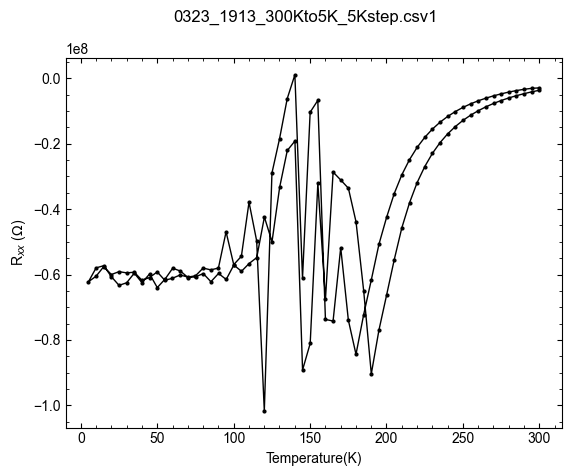

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

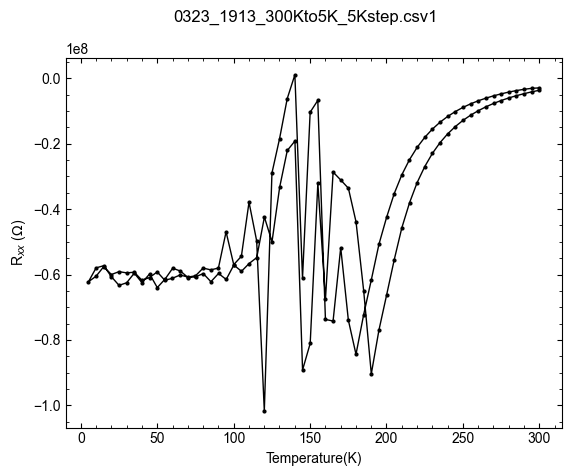

In [10]:
Temps=createArraywithSteps([300,5,300],[-5,5])
note='300Kto5K_5Kstep'
VoltMeasWithInputT(Temps, sample_id='Daniel_LCO(20nm)_LSAT(001)_RvsT_50nA',dc_current=5e-8, wait_after_hall=2, satfield=0,note=note,
                           dc=dc,volt=volt, ppms=ppms,longnote='')

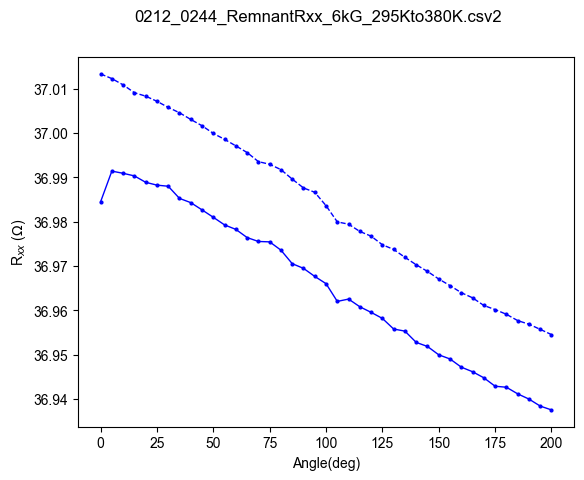

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

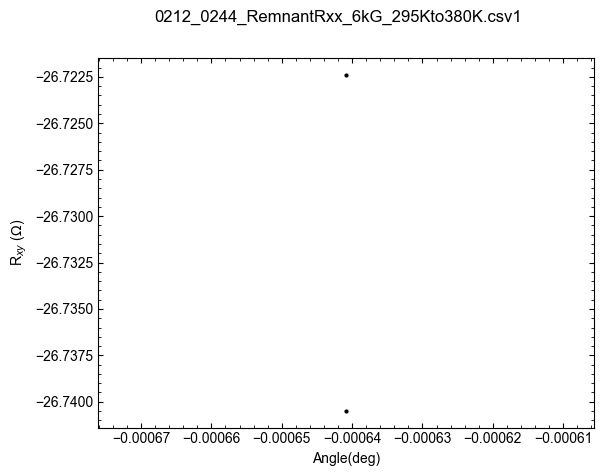

<Figure size 640x480 with 0 Axes>

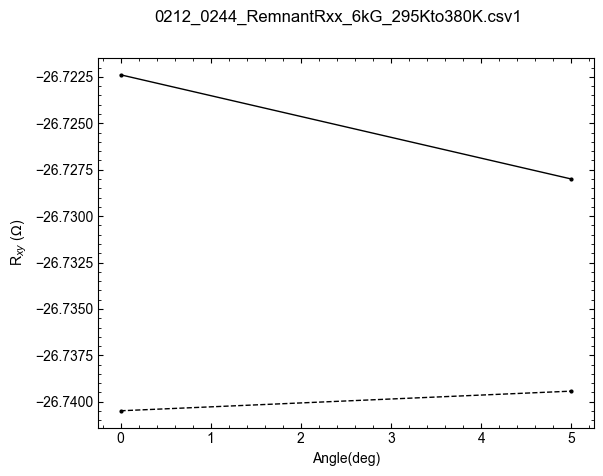

<Figure size 640x480 with 0 Axes>

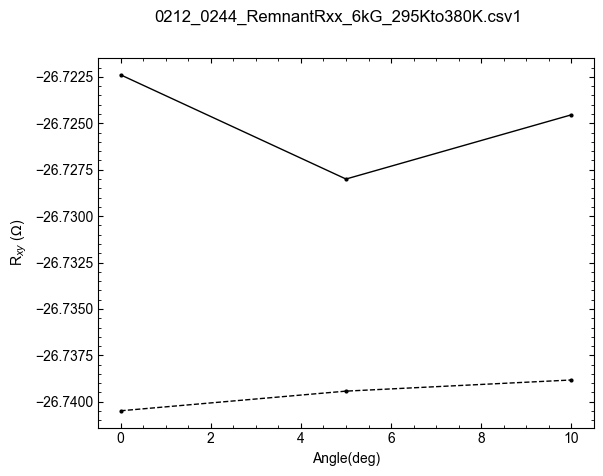

<Figure size 640x480 with 0 Axes>

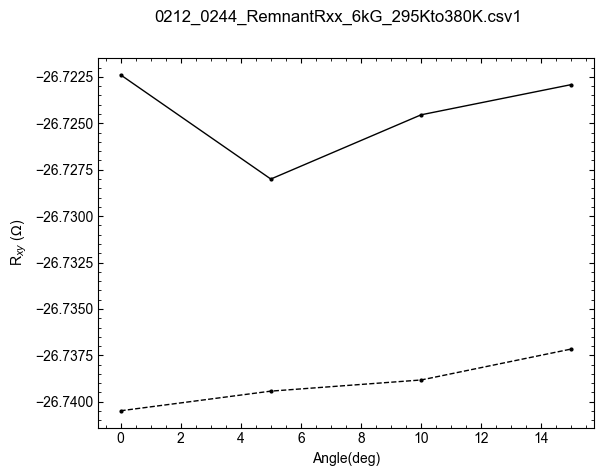

<Figure size 640x480 with 0 Axes>

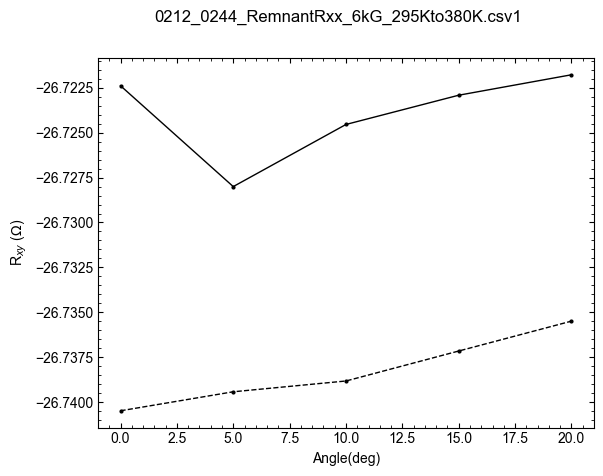

<Figure size 640x480 with 0 Axes>

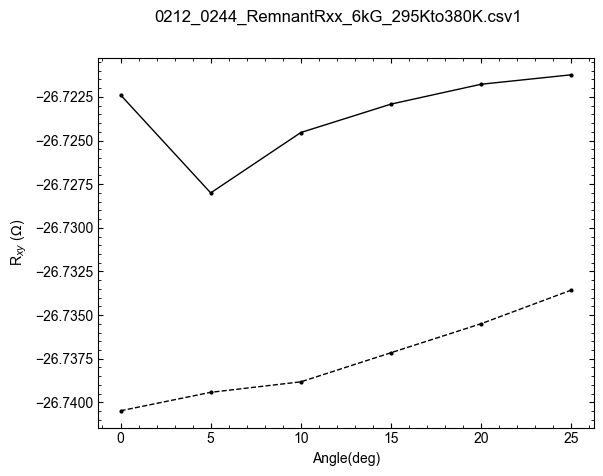

<Figure size 640x480 with 0 Axes>

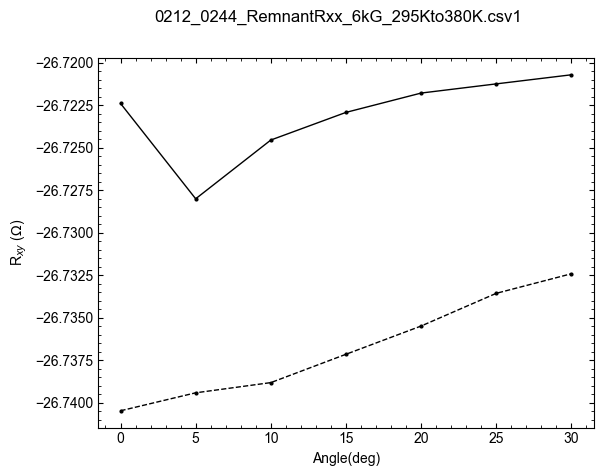

<Figure size 640x480 with 0 Axes>

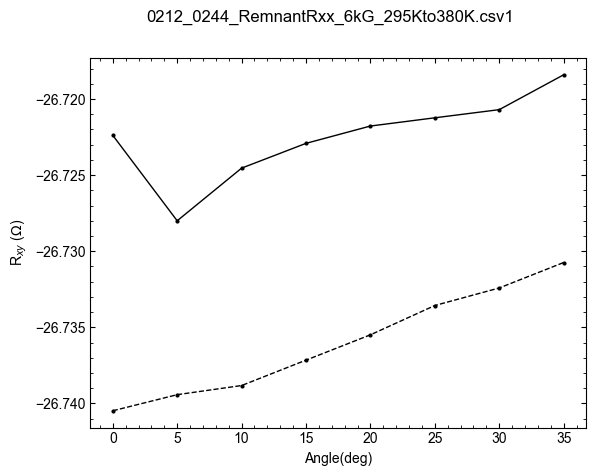

<Figure size 640x480 with 0 Axes>

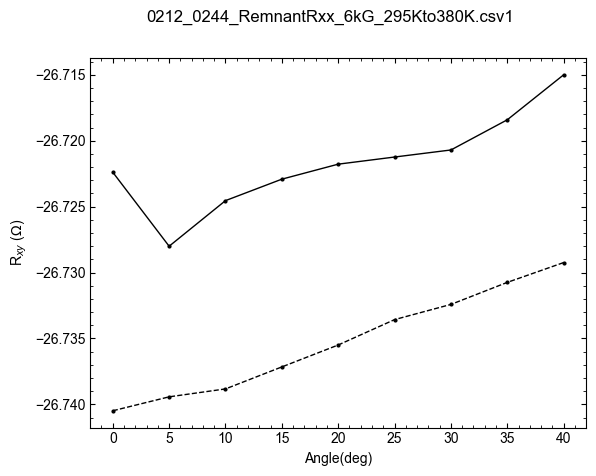

<Figure size 640x480 with 0 Axes>

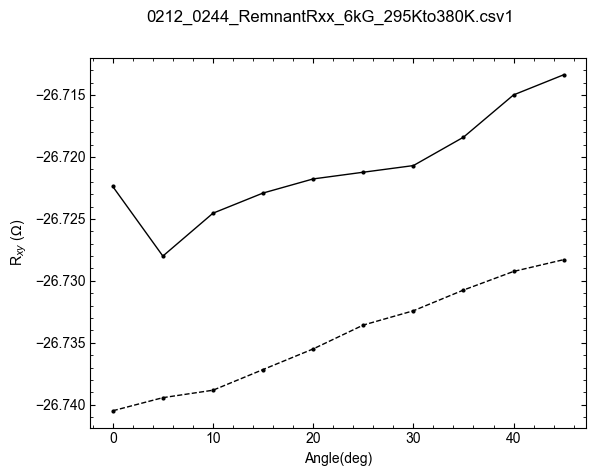

<Figure size 640x480 with 0 Axes>

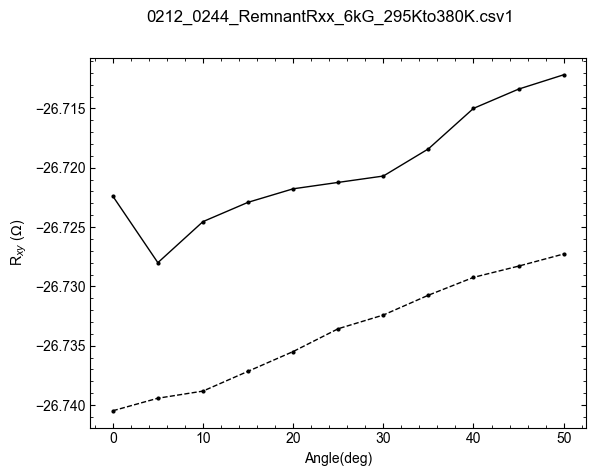

<Figure size 640x480 with 0 Axes>

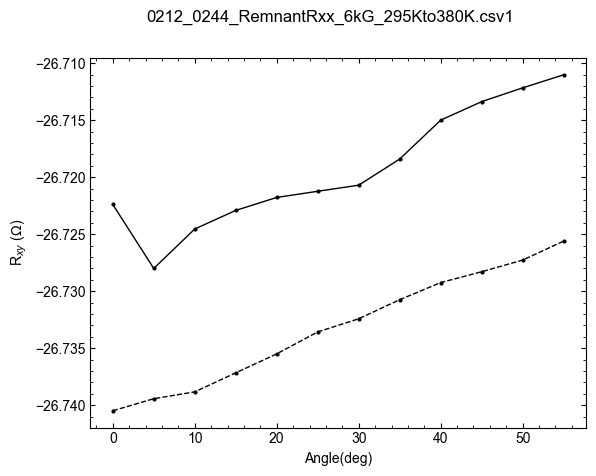

<Figure size 640x480 with 0 Axes>

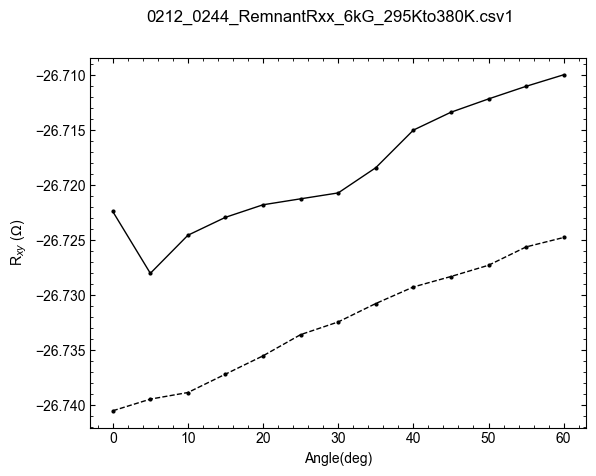

<Figure size 640x480 with 0 Axes>

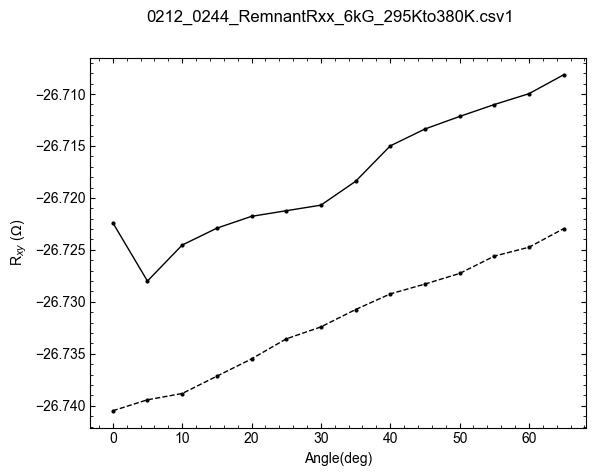

<Figure size 640x480 with 0 Axes>

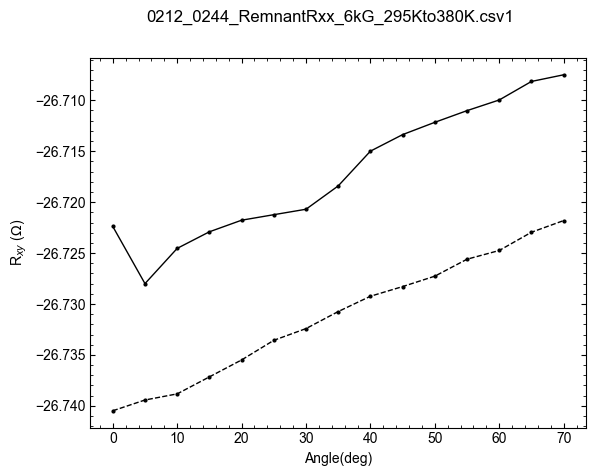

<Figure size 640x480 with 0 Axes>

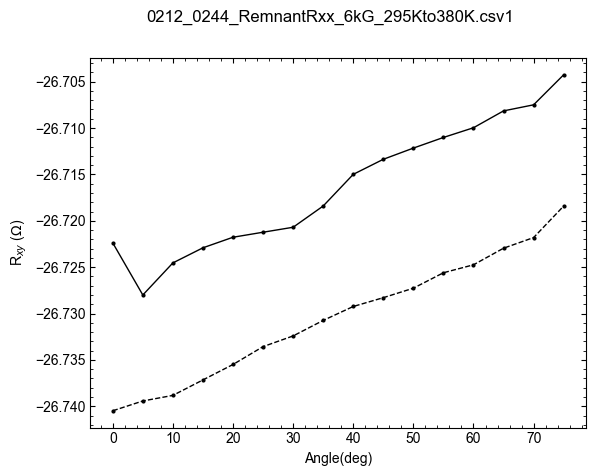

<Figure size 640x480 with 0 Axes>

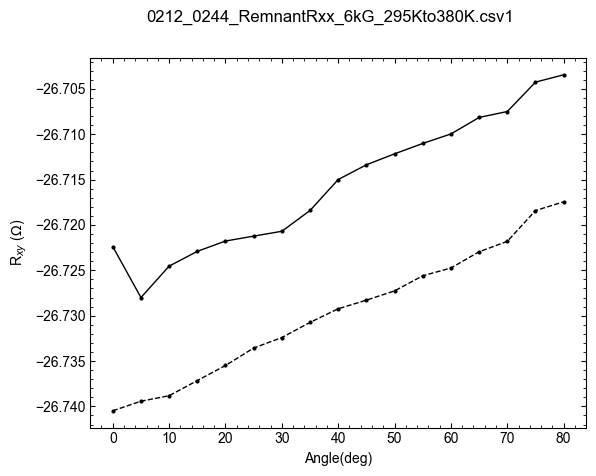

<Figure size 640x480 with 0 Axes>

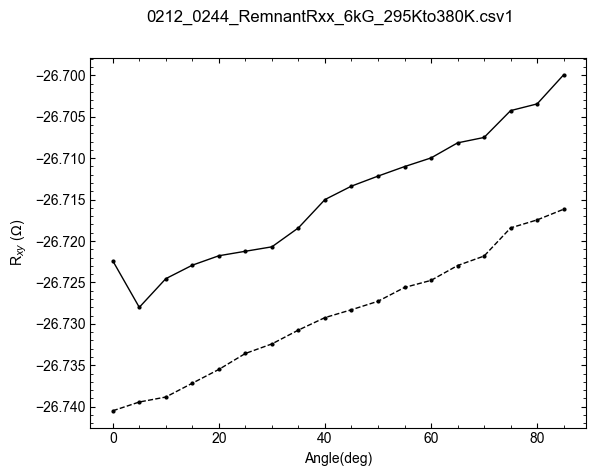

<Figure size 640x480 with 0 Axes>

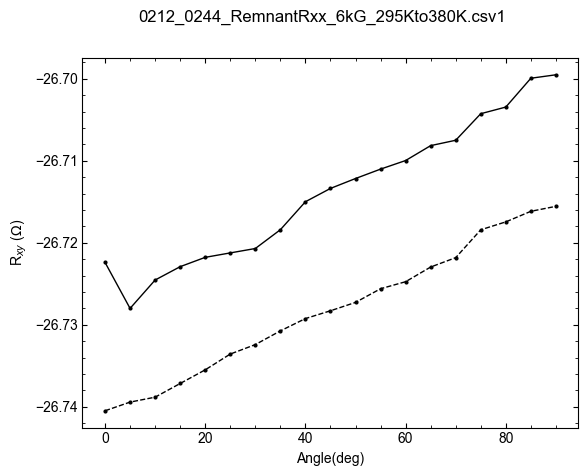

<Figure size 640x480 with 0 Axes>

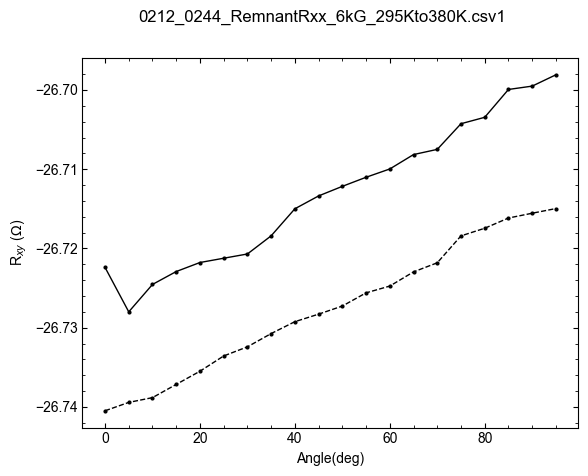

<Figure size 640x480 with 0 Axes>

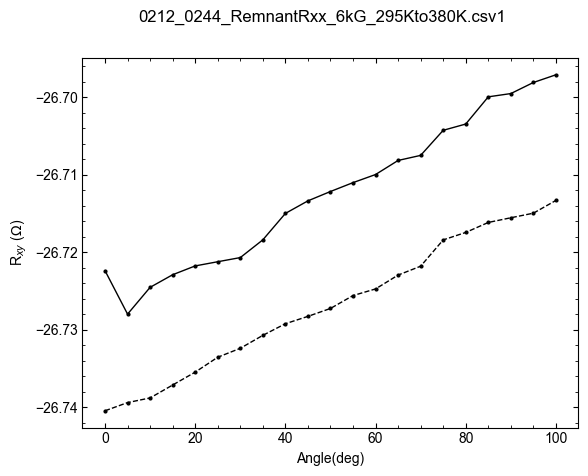

<Figure size 640x480 with 0 Axes>

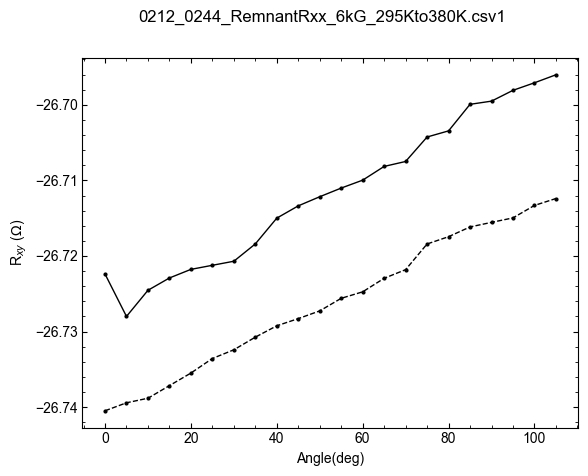

<Figure size 640x480 with 0 Axes>

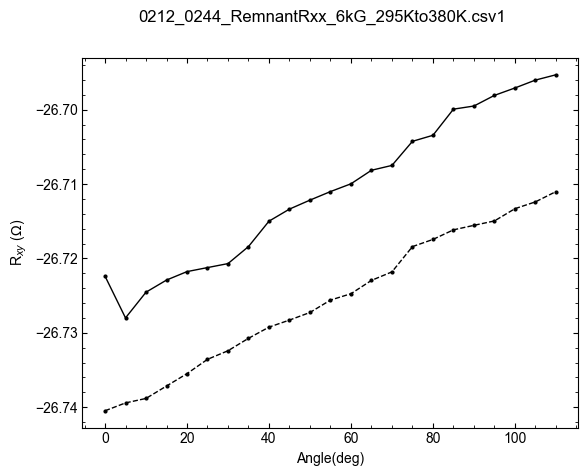

<Figure size 640x480 with 0 Axes>

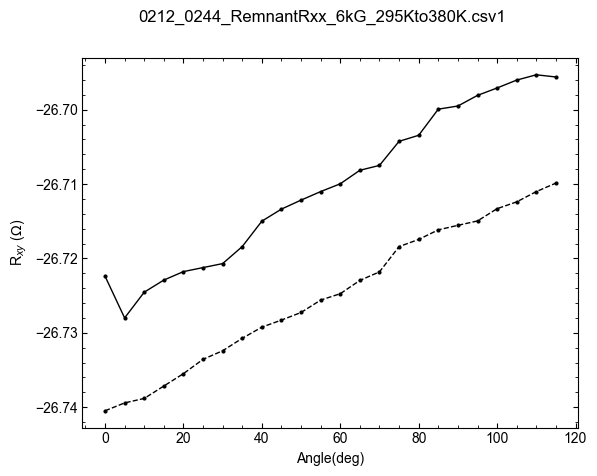

<Figure size 640x480 with 0 Axes>

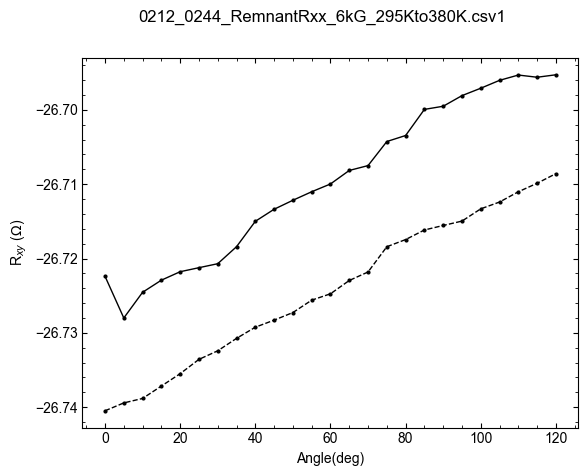

<Figure size 640x480 with 0 Axes>

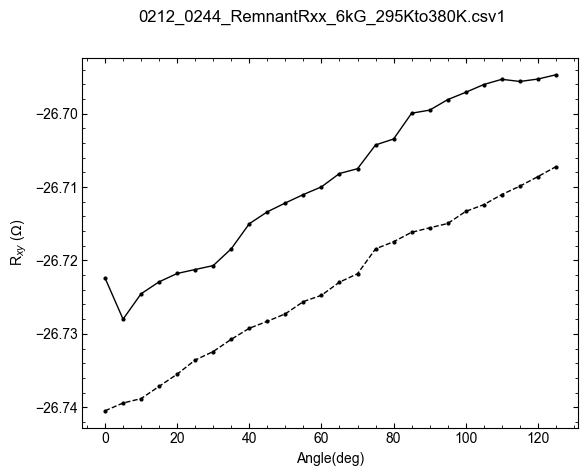

<Figure size 640x480 with 0 Axes>

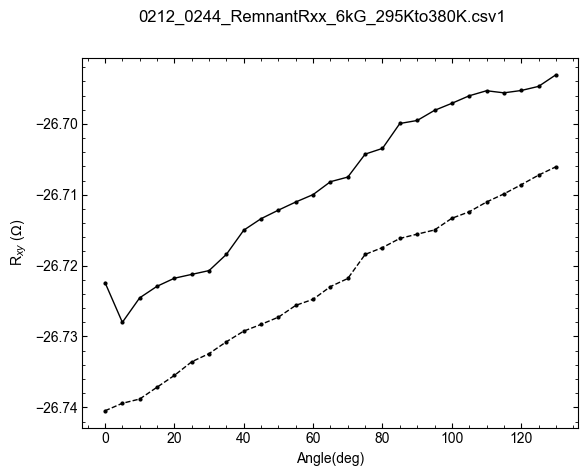

<Figure size 640x480 with 0 Axes>

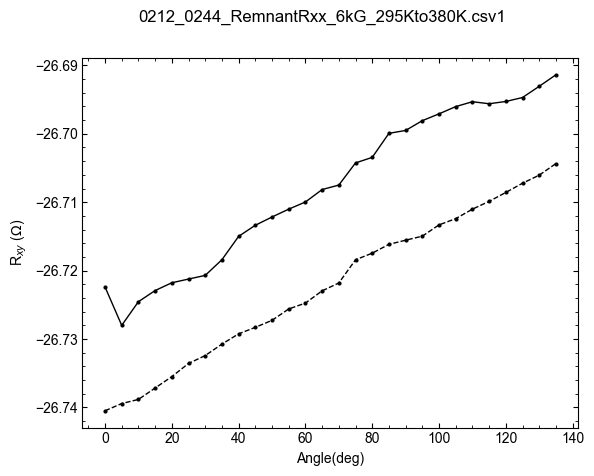

<Figure size 640x480 with 0 Axes>

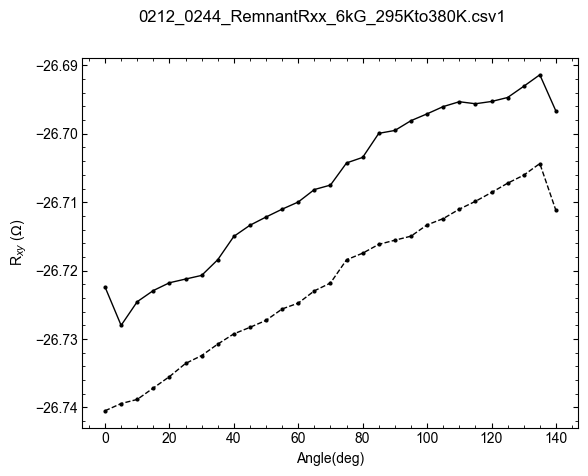

<Figure size 640x480 with 0 Axes>

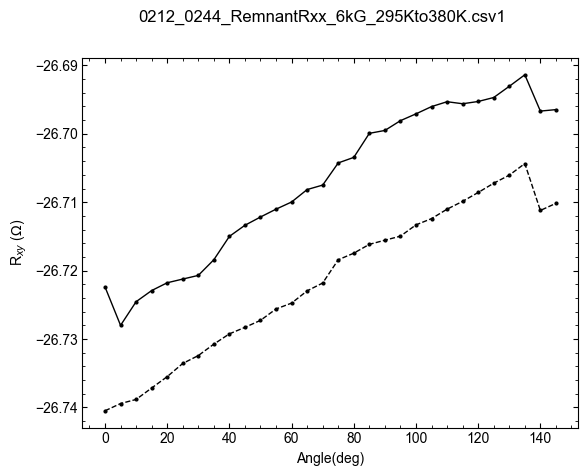

<Figure size 640x480 with 0 Axes>

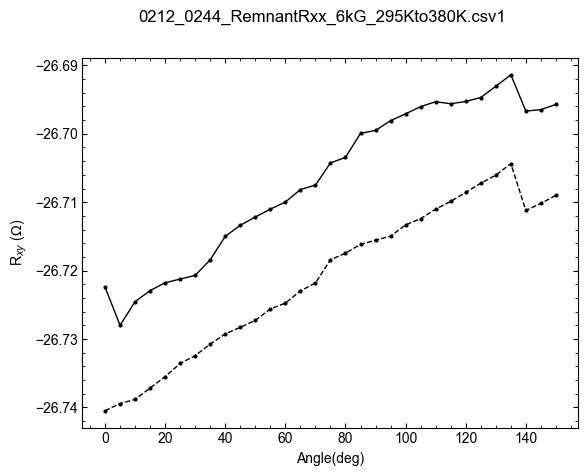

<Figure size 640x480 with 0 Axes>

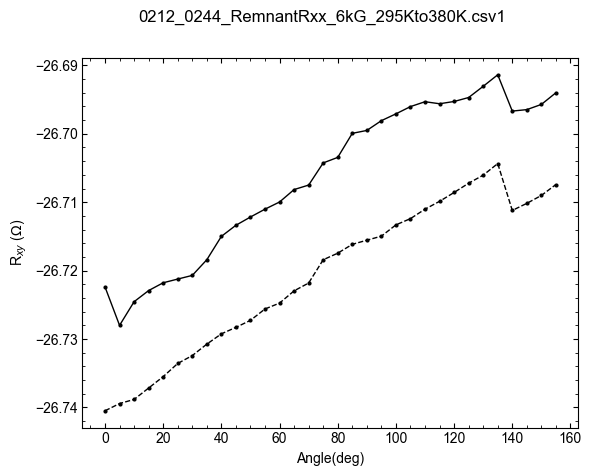

<Figure size 640x480 with 0 Axes>

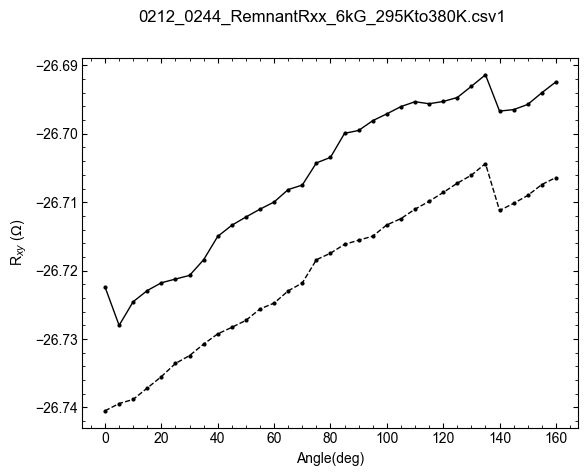

<Figure size 640x480 with 0 Axes>

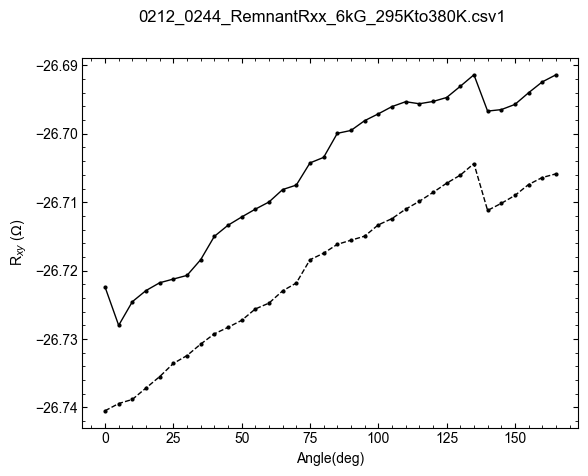

<Figure size 640x480 with 0 Axes>

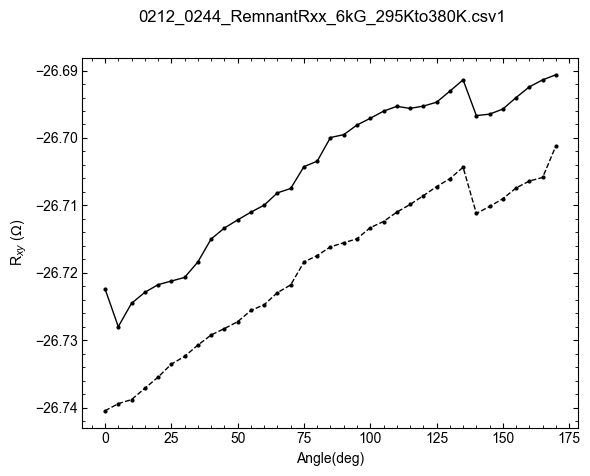

<Figure size 640x480 with 0 Axes>

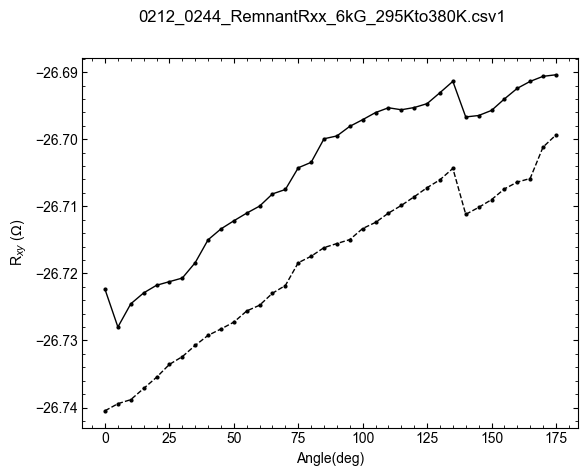

<Figure size 640x480 with 0 Axes>

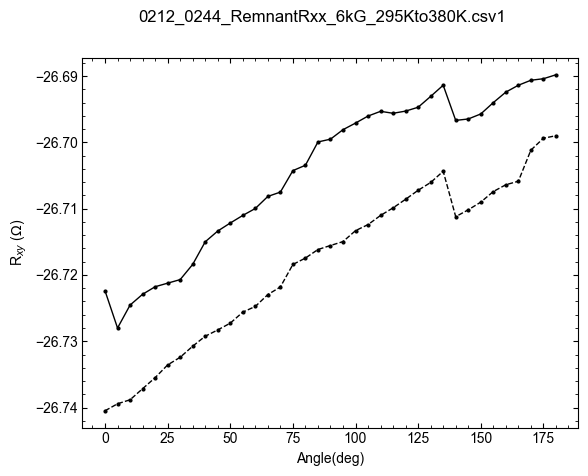

<Figure size 640x480 with 0 Axes>

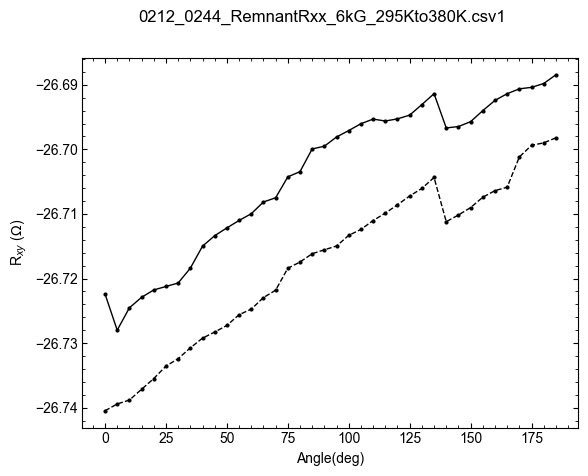

<Figure size 640x480 with 0 Axes>

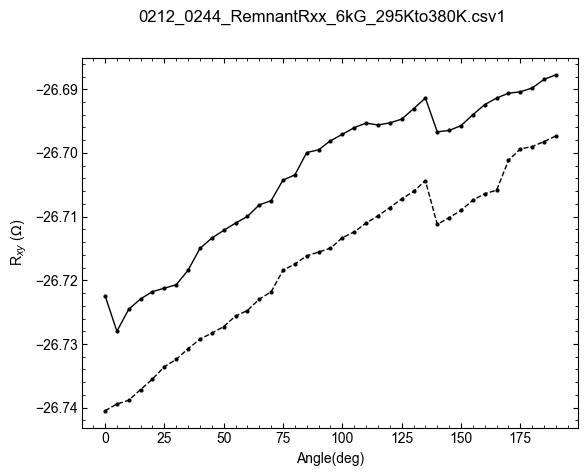

<Figure size 640x480 with 0 Axes>

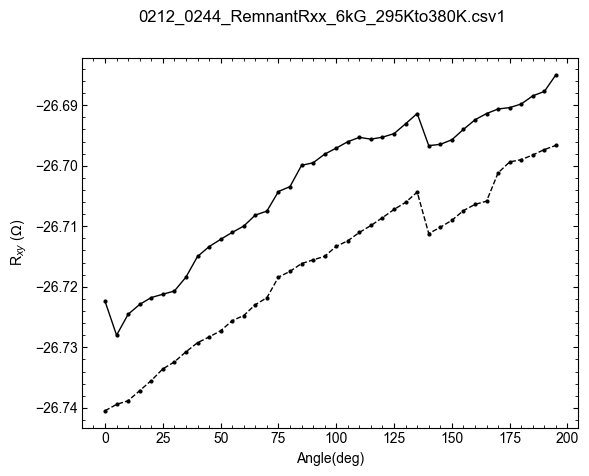

<Figure size 640x480 with 0 Axes>

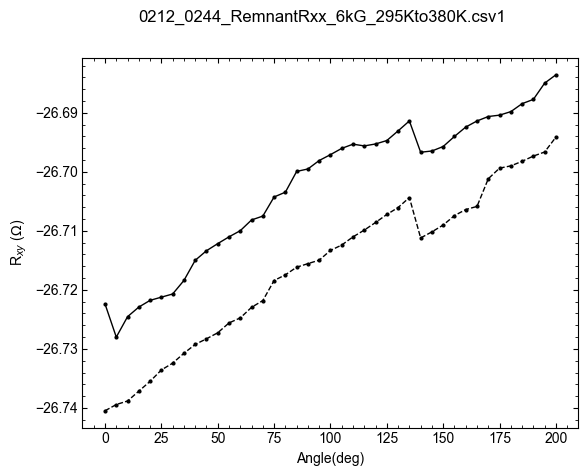

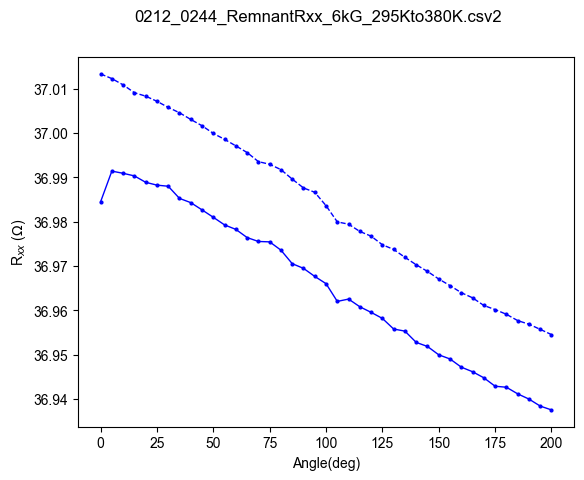

In [13]:

angles=createArraywithSteps([0,200,0],[5,-5])
note='RemnantRxx_6kG_295Kto380K'
VoltMeasWithInputAnglesTrise(angles, sample_id='LSC691_CD_Ag(50)_Pt(2.5)_Fe2O3(15)_Al2O3(0001)',dc_current=2e-4, wait_after_hall=2, satfield=6000,fieldON=False,note=note,
                           dc=dc,dc2=dc2,volt=volt,volt2=volt2, ppms=ppms,longnote='',temp=380)

In [2]:
connect2PPMS('192.168.0.7')

Successfully pinged the PPMS IP address 192.168.0.7 
The PPMS: <UtilsPPMS.Dynacool object at 0x00000140E59D98D0>
Current field: -0.0372360534965992G
Current temperature: 299.8503723144531K


In [4]:
ppms.setPosition(0)
ppms.waitForPosition()

0

## List connected devices

In [29]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR',
 'ASRL5::INSTR',
 'ASRL10::INSTR',
 'GPIB0::10::INSTR',
 'GPIB0::16::INSTR')

## Keithley 6221 AC current source
Connects to the 6221 and first outputs a pulse, followed by a sine wave

In [30]:
from UtilsKeithley6221 import *

#Test Keithley 6221 connection. If it cannot connect, check the GPIB port (specify with K6221(GPIBnum=#))
ac=K6221()
#Output a 10uA pulse
ac.pulseOut()
#Output a 10uA indefinite length sine wave
ac.sinOut()

## SR865A Lock-In Amplifier 
Connects to and reads the Lock in parameters

In [31]:
from UtilsSR865A import *
lock=Lockin()
lock.readLockin()

(6.5432664087e-07, -1.3170010789e-06, 1.2890700418e-06, -127.38214111)

In [32]:
from UtilsBasic import *
createArraywithSteps([1,10],[2])

The final array generated is  [1, 3, 5, 7, 9, 10]


[1, 3, 5, 7, 9, 10]